In [1]:
import os

os.chdir('/Users/gabriele/PycharmProjects/RecSys')
from Utils.utils import create_URM, create_ICM, combine_matrices, create_submission, write_submission
from src.Evaluation.Evaluator import EvaluatorHoldout
from src.Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
##NON-PERSONALIZED
from src.Recommenders.Base.NonPersonalizedRecommender import TopPop

#KNN
from src.Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from src.Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from src.Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from src.Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
from src.Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

#MATRIX-FACTORIZATION
from src.Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from src.Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from src.Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from src.Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from src.Recommenders.MatrixFactorization.IALSRecommenderLinear import IALSRecommender
from src.Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

#GRAPHIC-BASED
from src.Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from src.Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

#HYBRID
from src.Hybrids.MergingModelsByScores import MergeTwoModelsByScores, MergeThreeModelsByScores
import numpy as np

In [2]:
URM = create_URM()
ICM = create_ICM()

URM_train_validation,URM_test = split_train_in_two_percentage_global_sample(URM,train_percentage=0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation,train_percentage=0.85)

combined_matrices = combine_matrices(ICM=ICM, URM=URM_train)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13639 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13626 ( 0.2%) Users that have less than 1 test interactions


In [3]:
ItemKNNCF_recommender = ItemKNNCFRecommender(URM_train = combined_matrices)
ItemKNNCF_recommender.fit(topK=273, shrink=5.0, similarity='cosine')

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 924.17 column/sec. Elapsed time 19.54 sec


In [10]:
ItemKNNCBF_recommender = ItemKNNCBFRecommender(URM_train =URM_train, ICM_train=ICM)
ItemKNNCBF_recommender.fit(topK=7,shrink=39.08250057579825,similarity="asymmetric")

ItemKNNCBFRecommender: ICM Detected 1 ( 0.0%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 5416.29 column/sec. Elapsed time 3.33 sec


In [5]:
W_sparse_CF = ItemKNNCF_recommender.W_sparse
W_sparse_CBF = ItemKNNCBF_recommender.W_sparse

In [6]:
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

W_sparse_CF_sorted

array([0.02674576, 0.02674576, 0.02680176, ..., 0.5635109 , 0.5637429 ,
       0.5637429 ], dtype=float32)

In [7]:
W_sparse_CBF_sorted

array([0.02386012, 0.02386012, 0.02386012, ..., 0.26374036, 0.26374036,
       0.26374036], dtype=float32)

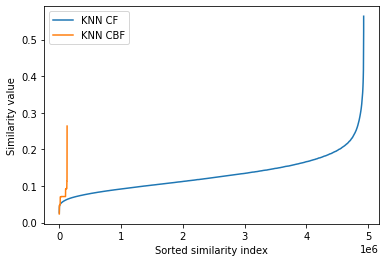

In [8]:
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'KNN CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'KNN CBF')
pyplot.ylabel('Similarity value')
pyplot.xlabel('Sorted similarity index')
pyplot.legend()
pyplot.show()

In [9]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

In [10]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())

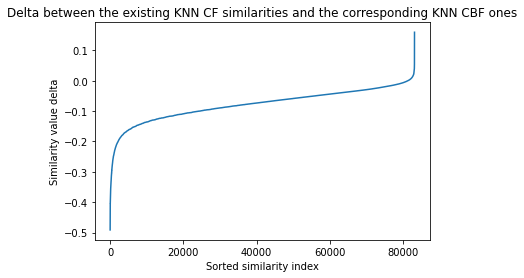

In [11]:
pyplot.plot(W_sparse_delta_sorted)
pyplot.ylabel('Similarity value delta')
pyplot.xlabel('Sorted similarity index')
pyplot.title("Delta between the existing KNN CF similarities and the corresponding KNN CBF ones")
pyplot.show()

In [12]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))

W_sparse_CF has 4.93E+06 values and 1.69 % in common with CBF
W_sparse_CBF has 1.26E+05 values and 65.74 % in common with CF
W_sparse_delta has 8.31E+04 values


In [11]:
from src.Recommenders.FeatureWeighting.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg

In [12]:
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer, Categorical
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs


def hyperparameter_optimization_CFW_D(URM_train, ICM_train, W_sparse_CF):

    recommender_class = CFW_D_Similarity_Linalg

    parameterSearch = SearchBayesianSkopt(recommender_class,
                                     evaluator_validation=evaluator_validation,
                                     evaluator_test=evaluator_test)


    hyperparameters_range_dictionary = {}
    hyperparameters_range_dictionary["topK"] = Integer(5, 1000)
    hyperparameters_range_dictionary["add_zeros_quota"] = Real(low = 0, high = 1, prior = 'uniform')
    hyperparameters_range_dictionary["normalize_similarity"] = Categorical([True, False])


    recommender_input_args = SearchInputRecommenderArgs(
        CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, ICM_train, W_sparse_CF],
        CONSTRUCTOR_KEYWORD_ARGS = {},
        FIT_POSITIONAL_ARGS = [],
        FIT_KEYWORD_ARGS = {}
    )


    output_folder_path = "./boosted"

    import os

    # If directory does not exist, create
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    n_cases = 30
    metric_to_optimize = "MAP"
    cutoff_to_optimize = 10




    parameterSearch.search(recommender_input_args,
                           hyperparameter_search_space = hyperparameters_range_dictionary,
                           n_cases = n_cases,
                           n_random_starts = int(n_cases/3),
                           save_model = "no",
                           evaluate_on_test = "last",
                           output_folder_path = output_folder_path,
                           output_file_name_root = recommender_class.RECOMMENDER_NAME,
                           metric_to_optimize = metric_to_optimize,
                           cutoff_to_optimize = cutoff_to_optimize
                          )

In [ ]:
hyperparameter_optimization_CFW_D(URM_train, ICM, W_sparse_CF)

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 816, 'add_zeros_quota': 0.8148243620663648, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: ICM Detected 1 ( 0.0%) items with no features.
CFW_D_Similarity_Linalg: Generating train data
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 3234.37 column/sec. Elapsed time 5.58 sec
CFW_D_Similarity_Linalg: Collaborative S density: 1.51E-02, nonzero cells 4930107
CFW_D_Similarity_Linalg: Content S density: 4.46E-02, nonzero cells 14548919
CFW_D_Similarity_Linalg: Generating train data. Sample 3396825 (42.4%) 
CFW_D_Similarity_Linalg: Generating train data. Sample 9974143 (124.4%) 
CFW_D_Similarity_Linalg: Content S structure has 2736120 out of 14548919 (18.8%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 3.72E+05, average is: 1.36E-01, average over all collaborative data is 1.31E-01
Unable 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 536.4206
Function value obtained: -0.0288
Current minimum: -0.0320
Iteration No: 5 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 679, 'add_zeros_quota': 0.6972062205595103, 'normalize_similarity': True}
CFW_D_Similarity_Linalg: ICM Detected 1 ( 0.0%) items with no features.
CFW_D_Similarity_Linalg: Generating train data
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 2535.79 column/sec. Elapsed time 7.12 sec
CFW_D_Similarity_Linalg: Collaborative S density: 1.51E-02, nonzero cells 4930107
CFW_D_Similarity_Linalg: Content S density: 3.73E-02, nonzero cells 12172278
CFW_D_Similarity_Linalg: Generating train data. Sample 3023682 (42.2%) 
CFW_D_Similarity_Linalg: Generating train data. Sample 9125175 (127.2%) 
CFW_D_Similarity_Linalg: Content S structure has 2582716 out of 12172278 (21.2%) nonzero collaborative cells
CFW_D_Similar